In [16]:
%matplotlib widget

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.analysis import raw_ch
from ephysvibe.task import task_constants,def_task
import os, glob

## Load data

In [18]:
directory="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/detect_rf/lip"
#directory='/home/INT/losada.c/Documents/codes/EphysVibe/output/lip'

In [19]:
rf_path = os.path.normpath(str(directory) + "/*.csv")
rf_path = glob.glob(rf_path, recursive=True)

In [20]:
rf_all = []
for n_path in rf_path:
    rf = pd.read_csv(n_path)
    rf = rf[~rf.isnull().any(axis=1)]
    rf_all.append(rf)
rf_all = pd.concat(rf_all).reset_index(drop=True)

In [15]:
rf_all#.head()

,array_position,neuron_type,i_neuron,event,rad,ang,fr_max,ang_max,rad_all,ang_all,depth,vm_index,date
0,2,mua,3,visual,0.746564,1.500666,50.865265,45.0,0.746564,1.500666,1250.0,-0.386417,2023-02-08_10-39-41
1,3,neuron,1,visual,0.407598,5.206117,82.200340,315.0,0.407598,5.206117,1350.0,-0.737374,2023-02-08_10-39-41
2,0,mua,1,visual,0.466507,5.707743,153.501464,315.0,0.466507,5.707743,1000.0,-0.483190,2023-03-03_10-59-32
3,0,mua,1,visual,0.233951,1.570796,26.604159,270.0,0.512631,1.570796,1000.0,-0.032258,2023-03-06_10-32-51
4,7,neuron,3,visual,0.947962,0.785398,26.077941,270.0,0.947962,0.785398,1200.0,-0.727811,2023-03-06_10-32-51
5,1,mua,1,visual,0.866792,4.347130,53.198900,270.0,0.866792,4.347130,950.0,-0.882353,2023-03-07_10-14-11
6,6,mua,5,visual,0.584590,4.766996,63.235732,270.0,0.584590,4.766996,1300.0,-0.513514,2023-03-07_10-14-11
7,7,mua,6,visual,0.571755,4.315553,57.664037,315.0,0.571755,4.315553,950.0,-0.552239,2023-03-07_10-14-11
8,2,neuron,2,visual,1.000000,4.712389,53.374426,270.0,1.000000,4.712389,750.0,-0.031684,2023-03-09_10-35-09
9,4,mua,3,visual,0.570507,0.000000,31.057860,270.0,0.582110,0.000000,650.0,-0.200000,2023-03-10_10-30-26


#### Prepare df 

In [8]:
# visual, motor, visuomotor
thres_vm = 0.3
v_df = rf_all[np.logical_and(rf_all['vm_index'] <= -thres_vm,rf_all['event']=='visual')].reset_index(drop=True)
m_df = rf_all[np.logical_and(rf_all['vm_index'] >= thres_vm,rf_all['event']=='motor')].reset_index(drop=True)
v_m_df = rf_all[np.logical_and(rf_all['vm_index'] < thres_vm,rf_all['vm_index']>-thres_vm)].reset_index(drop=True)
v_m_df =v_m_df.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)

print('Total number of neurons: %d'%(len(v_df)+len(m_df)+len(v_m_df)))
print('number of visual %d, motor %d, visualmotor %d'%(len(v_df),len(m_df),len(v_m_df)))

Total number of neurons: 51
number of visual 29, motor 11, visualmotor 11


In [9]:
# ipsi - contra 
rf_no_dup = rf_all.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)
no_pref = rf_no_dup[rf_no_dup['p_lat']>=0.05]
pref= rf_no_dup[rf_no_dup['p_lat']<0.05]
df_contra = pref[pref['lat_index']>=0]
df_ipsi = pref[pref['lat_index']<0]
print('Total number of neurons: %d'%(len(df_ipsi)+len(df_contra)+len(no_pref)))
print('Number of ipsi: %d, contra: %d, no preference: %d'%(len(df_ipsi),len(df_contra),len(no_pref)))

Total number of neurons: 51
Number of ipsi: 8, contra: 29, no preference: 14


In [10]:
# a=rf_all[['date','array_position']].groupby(['date','array_position']).size().reset_index().rename(columns={0:'count'})
# print('Total number of neurons: %d'%len(a))

## Number of ipsi vs number of contra

#### Laterality index

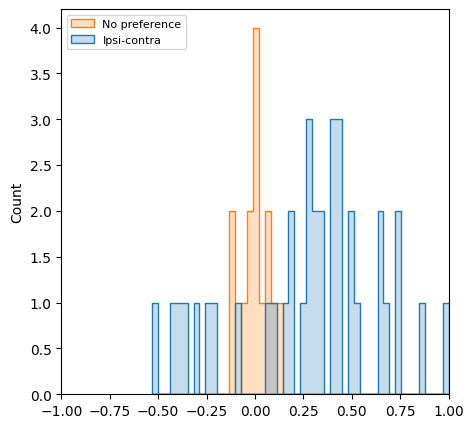

In [11]:
fig,ax = plt.subplots(figsize=(5,5))
ax_pref = sns.histplot([pref['lat_index'].values,no_pref['lat_index'].values], element="step",bins=50, ax=ax)

plt.legend(('No preference','Ipsi-contra'),loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 8})
a=plt.xlim(-1,1)

##### Using the mean angle

Number of ipsi: 5, contra: 46


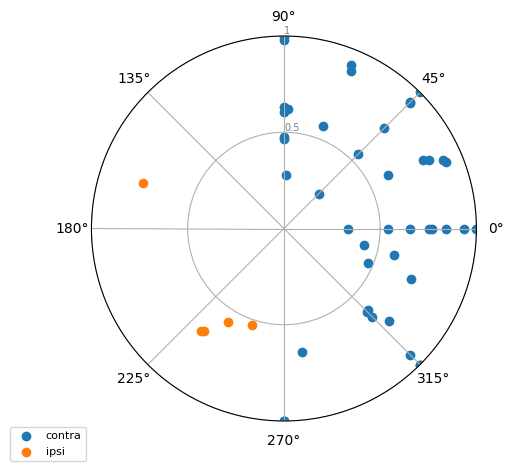

In [12]:
u_lim = 90*np.pi/180
d_lim = 270*np.pi/180

ipsi = rf_no_dup[np.logical_and(rf_no_dup['ang']>u_lim,rf_no_dup['ang']<d_lim)]
contra = rf_no_dup[np.logical_or(rf_no_dup['ang']>=d_lim,rf_no_dup['ang']<=u_lim)]
#plot
fig,ax = plt.subplots(figsize=(5,5),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
ax.set_rlabel_position(90)
ax.set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)

ax.scatter(contra['ang'],contra['rad'],label='contra')
ax.scatter(ipsi['ang'],ipsi['rad'],label='ipsi')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})
plt.ylim(0,1)
print('Number of ipsi: %d, contra: %d'%( len(ipsi), len(contra)))

##### Using the mean angle motor/visual

Visual-> number of ipsi: 3, contra: 26
Motor-> number of ipsi: 0, contra: 11


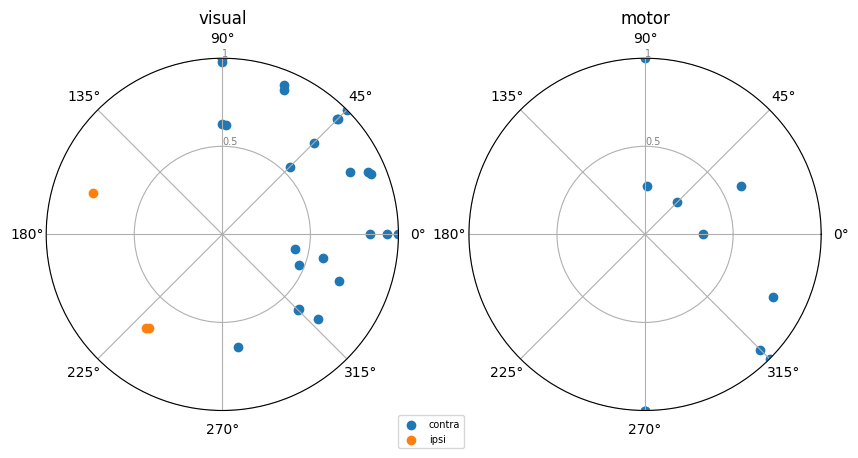

In [13]:
u_lim = 90*np.pi/180
d_lim = 270*np.pi/180
#visual
v_ipsi = v_df[np.logical_and(v_df['ang']>u_lim,v_df['ang']<d_lim)]
v_contra = v_df[np.logical_or(v_df['ang']>=d_lim,v_df['ang']<=u_lim)]
# motor
m_ipsi = m_df[np.logical_and(m_df['ang']>u_lim,m_df['ang']<d_lim)]
m_contra = m_df[np.logical_or(m_df['ang']>=d_lim,m_df['ang']<=u_lim)]
#plot
fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
ax[0].set_rlabel_position(90)
ax[0].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)
ax[1].set_rlabel_position(90)
ax[1].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)

ax[0].scatter(v_contra['ang'],v_contra['rad'],label='contra')
ax[0].scatter(v_ipsi['ang'],v_ipsi['rad'],label='ipsi')
ax[1].scatter(m_contra['ang'],m_contra['rad'],label='contra')
ax[1].scatter(m_ipsi['ang'],m_ipsi['rad'],label='ipsi')
plt.ylim(0,1)
ax[0].set_title('visual')
ax[1].set_title('motor')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 7})
print('Visual-> number of ipsi: %d, contra: %d'%( len(v_ipsi), len(v_contra)))
print('Motor-> number of ipsi: %d, contra: %d'%( len(m_ipsi), len(m_contra)))

##### Using the position
contra: 90, 45, 0, 315
ipsi: 135, 180, 225, 270

Visual-> number of ipsi: 8, contra: 21
Motor-> number of ipsi: 5, contra: 6


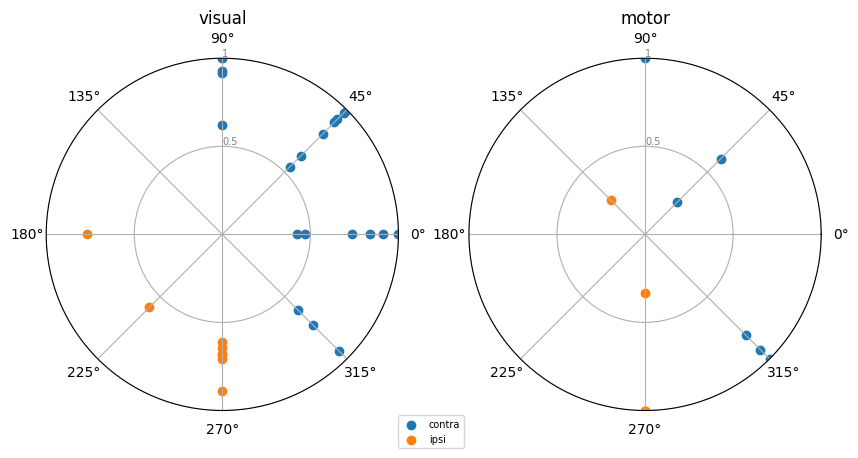

In [14]:
u_lim = 100
d_lim = 280
#visual
v_ipsi = v_df[np.logical_and(v_df['ang_max']>u_lim,v_df['ang_max']<d_lim)]
v_contra = v_df[np.logical_or(v_df['ang_max']>=d_lim,v_df['ang_max']<=u_lim)]
# motor
m_ipsi = m_df[np.logical_and(m_df['ang_max']>u_lim,m_df['ang_max']<d_lim)]
m_contra = m_df[np.logical_or(m_df['ang_max']>=d_lim,m_df['ang_max']<=u_lim)]
#plot
fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
ax[0].set_rlabel_position(90)
ax[0].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)
ax[1].set_rlabel_position(90)
ax[1].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)
ax[0].scatter(v_contra['ang_max']*np.pi/180,v_contra['rad'],label='contra')
ax[0].scatter(v_ipsi['ang_max']*np.pi/180,v_ipsi['rad'],label='ipsi')
ax[1].scatter(m_contra['ang_max']*np.pi/180,m_contra['rad'],label='contra')
ax[1].scatter(m_ipsi['ang_max']*np.pi/180,m_ipsi['rad'],label='ipsi')
plt.ylim(0,1)
ax[0].set_title('visual')
ax[1].set_title('motor')
ax[1].legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 7})
print('Visual-> number of ipsi: %d, contra: %d'%( len(v_ipsi), len(v_contra)))
print('Motor-> number of ipsi: %d, contra: %d'%( len(m_ipsi), len(m_contra)))

#### Using mean angle all

Number of no_pref: 14, pref: 37


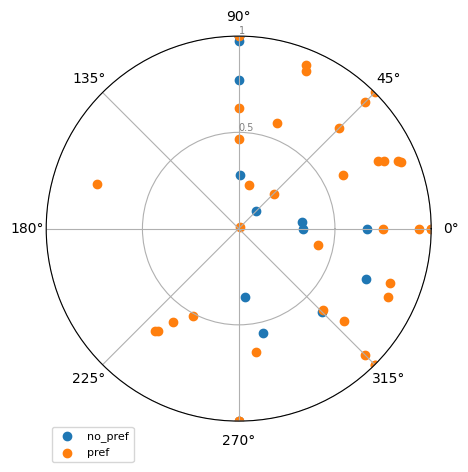

In [15]:
#plot
fig,ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': 'polar'})
ax.set_rlabel_position(90)
ax.set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)

ax.scatter(no_pref['ang_all'],no_pref['rad_all'],label='no_pref')
ax.scatter(pref['ang_all'],pref['rad_all'],label='pref')
ax.legend(loc='upper left', bbox_to_anchor=(0, 0), prop={'size': 8})
ax.set_ylim(0,1)
print('Number of no_pref: %d, pref: %d'%( len(no_pref), len(pref)))

# Spatial location

In [16]:
df_depth = pd.read_csv("/home/INT/losada.c/Downloads/recordings_info.csv")[['file_name','depth_in_lip','locacion_p','locacion_l']]
rf_depth = rf_all.merge(df_depth, left_on='date', right_on='file_name')
rf_depth['total_depth'] =  rf_depth['depth'] *(rf_depth['depth_in_lip']*1000) /1600

In [17]:
# visual, motor, visuomotor
thres_vm = 0.3
v_df_depth = rf_depth[np.logical_and(rf_depth['vm_index'] <= -thres_vm,rf_depth['event']=='visual')].reset_index(drop=True)
m_df_depth = rf_depth[np.logical_and(rf_depth['vm_index'] >= thres_vm,rf_depth['event']=='motor')].reset_index(drop=True)
v_m_df_depth = rf_depth[np.logical_and(rf_depth['vm_index'] < thres_vm,rf_depth['vm_index']>-thres_vm)].reset_index(drop=True)
v_m_df_depth =v_m_df_depth.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)

print('Total number of neurons: %d'%(len(v_df_depth)+len(m_df_depth)+len(v_m_df_depth)))
print('number of visual %d, motor %d, visualmotor %d'%(len(v_df_depth),len(m_df_depth),len(v_m_df_depth)))

Total number of neurons: 51
number of visual 29, motor 11, visualmotor 11


In [18]:
# ipsi - contra 
rf_depth_no_dup = rf_depth.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)
no_pref_depth = rf_depth_no_dup[rf_depth_no_dup['p_lat']>=0.05]
pref_depth= rf_depth_no_dup[rf_depth_no_dup['p_lat']<0.05]
df_contra_depth = pref_depth[pref_depth['lat_index']>=0]
df_ipsi_depth = pref_depth[pref_depth['lat_index']<0]
print('Total number of neurons: %d'%(len(df_ipsi_depth)+len(df_contra_depth)+len(no_pref_depth)))
print('Number of ipsi: %d, contra: %d, no preference: %d'%(len(df_ipsi_depth),len(df_contra_depth),len(no_pref_depth)))

Total number of neurons: 51
Number of ipsi: 8, contra: 29, no preference: 14


### visual - motor

Number of motor: 11, visual: 29


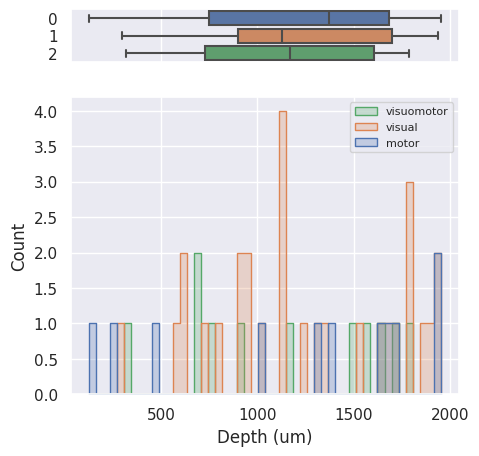

In [19]:
sns.set(style="darkgrid")

print('Number of motor: %d, visual: %d'%( len(m_df_depth), len(v_df_depth)))
fig,(ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(5,5), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot([m_df_depth['total_depth'].values,v_df_depth['total_depth'].values,v_m_df_depth['total_depth'].values], ax=ax_box,orient='horizontal')
sns.histplot([m_df_depth['total_depth'].values,v_df_depth['total_depth'].values,v_m_df_depth['total_depth'].values], element="step",bins=50, ax=ax_hist,legend=True)
ax_hist.set_xlabel('Depth (um)')
plt.legend(['visuomotor', 'visual','motor'], prop={'size': 8})


Number of motor: 11, visual: 29
Number of motor: 11, visual: 29


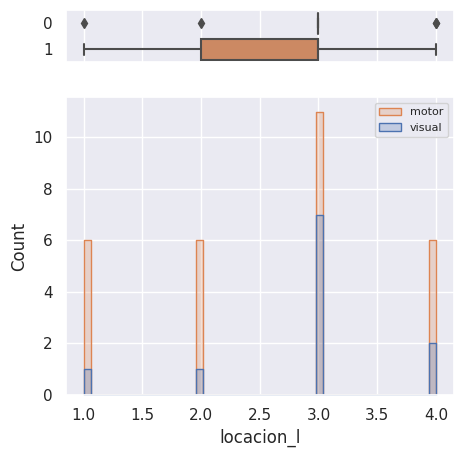

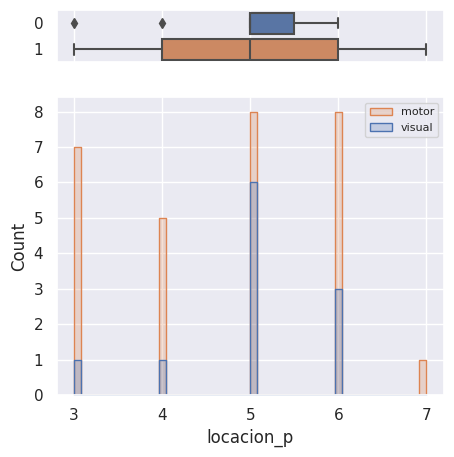

In [21]:
sns.set(style="darkgrid")
rf_motor = m_df_depth['locacion_l']
rf_visual = v_df_depth['locacion_l']

print('Number of motor: %d, visual: %d'%( len(rf_motor), len(rf_visual)))
fig,(ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(5,5), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot([rf_motor.values,rf_visual.values], ax=ax_box,orient='horizontal')
sns.histplot([rf_motor.values,rf_visual.values], element="step",bins=50, ax=ax_hist,legend=True)
ax_hist.set_xlabel('locacion_l')
plt.legend(['motor', 'visual'], prop={'size': 8})

rf_motor = m_df_depth['locacion_p']
rf_visual = v_df_depth['locacion_p']

print('Number of motor: %d, visual: %d'%( len(rf_motor), len(rf_visual)))
fig,(ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(5,5), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot([rf_motor.values,rf_visual.values], ax=ax_box,orient='horizontal')
sns.histplot([rf_motor.values,rf_visual.values], element="step",bins=50, ax=ax_hist,legend=True)
ax_hist.set_xlabel('locacion_p')
plt.legend(['motor', 'visual'], prop={'size': 8})

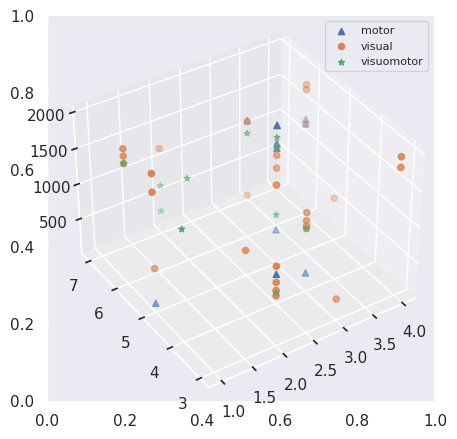

In [22]:
sns.set(style="darkgrid")
l_motor = m_df_depth['locacion_l']
p_motor = m_df_depth['locacion_p']
d_motor = m_df_depth['total_depth']
l_visual = v_df_depth['locacion_l']
p_visual = v_df_depth['locacion_p']
d_visual = v_df_depth['total_depth']
l_v_m = v_m_df_depth['locacion_l']
p_v_m = v_m_df_depth['locacion_p']
d_v_m = v_m_df_depth['total_depth']


fig,ax = plt.subplots(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l_motor.values,p_motor.values,d_motor.values,marker='^')
ax.scatter(l_visual.values,p_visual.values,d_visual.values)
ax.scatter(l_v_m.values,p_v_m.values,d_v_m.values,marker='*')
#sns.scatterplot(x=l_visual.values,y=p_visual.values, ax=ax)
#ax_hist.set_xlabel('locacion_l')
plt.legend(['motor', 'visual','visuomotor'], prop={'size': 8})
ax.view_init(37, -123)
plt.show()

In [20]:
plt.close()

Text(0.5, 1.0, 'visuomotor')

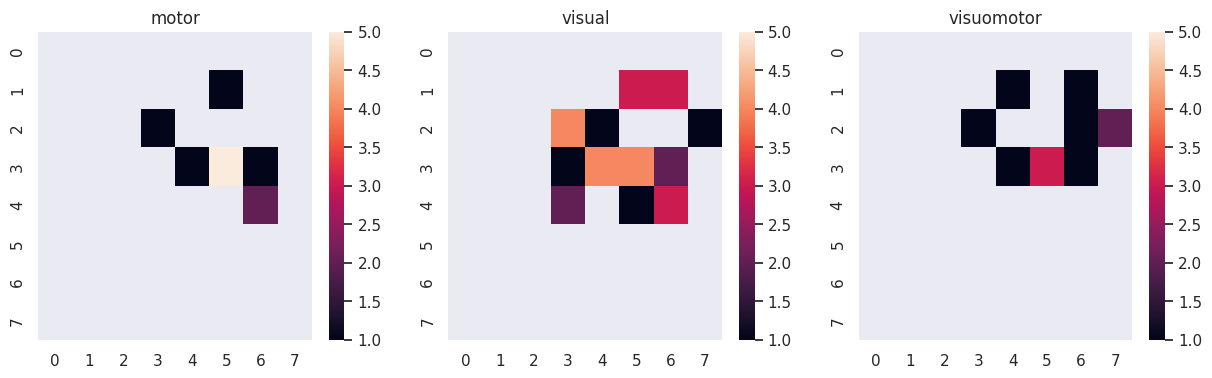

In [23]:
vmax = 5
count_df_m = m_df_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_v = v_df_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_vm = v_m_df_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})

m_vals=count_df_m.pivot_table(index = ['locacion_l'] ,columns=['locacion_p'],values='count')
v_vals=count_df_v.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')
vm_vals=count_df_vm.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')

m_vals.columns.name = None 
m_vals.index.name=None
m_vals_all=np.full((8,8),np.nan)
m_vals_all[m_vals.index[0]:m_vals.index[-1]+1, m_vals.columns[0]:m_vals.columns[-1]+1]=m_vals
v_vals.columns.name = None 
v_vals.index.name=None
v_vals_all=np.full((8,8),np.nan)
v_vals_all[v_vals.index[0]:v_vals.index[-1]+1, v_vals.columns[0]:v_vals.columns[-1]+1]=v_vals
vm_vals.columns.name = None 
vm_vals.index.name=None
vm_vals_all=np.full((8,8),np.nan)
vm_vals_all[vm_vals.index[0]:vm_vals.index[-1]+1, vm_vals.columns[0]:vm_vals.columns[-1]+1]=vm_vals
fig,(ax_m,ax_v,ax_vm) = plt.subplots(ncols=3,figsize=(15,4))
sns.heatmap(m_vals_all,ax=ax_m,vmax=vmax)
sns.heatmap(v_vals_all,ax=ax_v,vmax=vmax)
sns.heatmap(vm_vals_all,ax=ax_vm,vmax=vmax)
ax_m.set_title('motor')
ax_v.set_title('visual')
ax_vm.set_title('visuomotor')

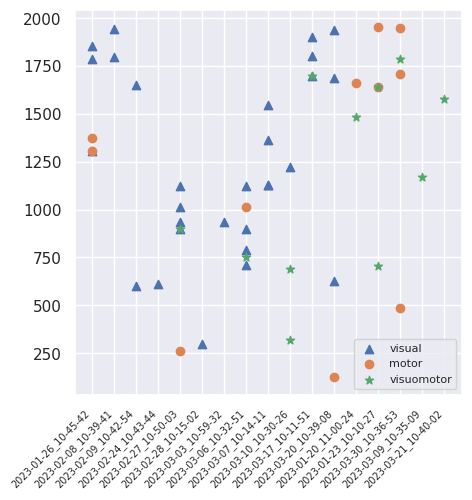

In [24]:
dt_v = v_df_depth['date']
d_v = v_df_depth['total_depth']
dt_m = m_df_depth['date']
d_m = m_df_depth['total_depth']
dt_vm = v_m_df_depth['date']
d_vm = v_m_df_depth['total_depth']
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(dt_v.values,d_v.values,marker='^')
ax.scatter(dt_m.values,d_m.values)
ax.scatter(dt_vm.values,d_vm.values,marker='*')
plt.xticks(rotation=45, ha='right',size=7)
plt.legend(['visual', 'motor','visuomotor'], prop={'size': 8})

plt.show()

### Laterality

In [23]:
my_colors = {0: 'purple', 1: 'pink', 2: 'gold'}

0.2386929544535881


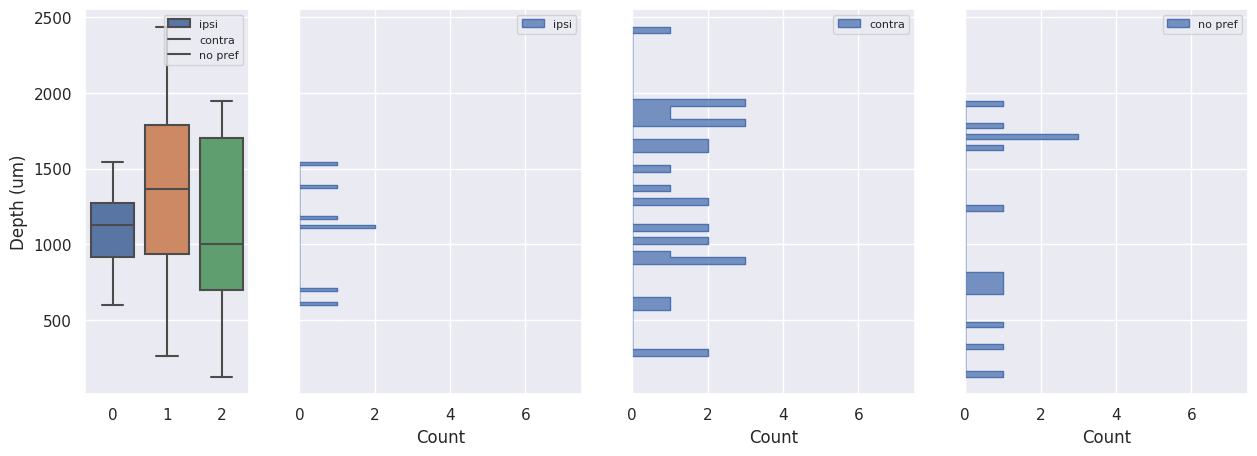

In [24]:
sns.set(style="darkgrid")


rf_dep_no_sig = no_pref_depth['total_depth']
rf_dep_sig = pref_depth

rf_contra = df_contra_depth['total_depth']
rf_ipsi = df_ipsi_depth['total_depth']


fig,(ax_box, ax1,ax2,ax3) = plt.subplots(1,4, sharey=True,figsize=(15,5), gridspec_kw={"width_ratios": (.11, .19,0.19,0.19)})
g = sns.boxplot([rf_ipsi.values,rf_contra.values,rf_dep_no_sig.values], ax=ax_box,orient='vertical')#,palette=my_colors)
g.legend(('ipsi', 'contra','no pref'), prop={'size': 8})
g.set_ylabel('Depth (um)')
g1=sns.histplot(y=rf_ipsi.values, element="step",bins=50,ax=ax1,legend=True)
g1.legend(['ipsi'], prop={'size': 8})
ax1.set_xlim(0,7.5)
g2=sns.histplot(y=rf_contra.values, element="step",bins=50,ax=ax2,legend=True)
g2.legend(['contra'], prop={'size': 8})
ax2.set_xlim(0,7.5)
g3=sns.histplot(y=rf_dep_no_sig.values, element="step",bins=50, ax=ax3,legend=True)
g3.legend(['no pref'], prop={'size': 8})
ax3.set_xlim(0,7.5)
#sns.histplot([rf_dep_no_sig.values], element="step",bins=50,ax=ax3,legend=True)
p=stats.ttest_ind(rf_ipsi.values, rf_contra.values)[1]
print(p)

0.4888165279548399
0.1011429915027859


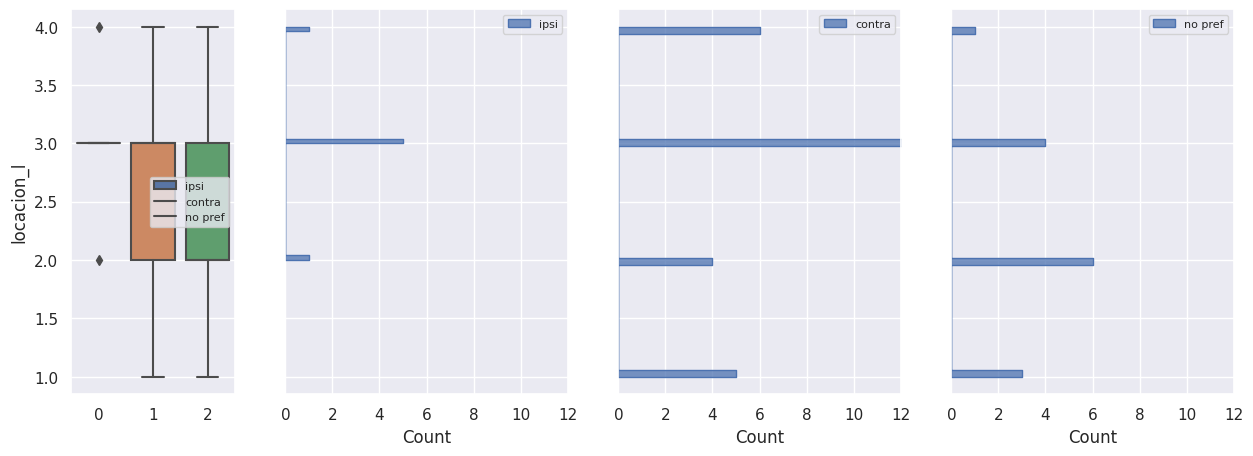

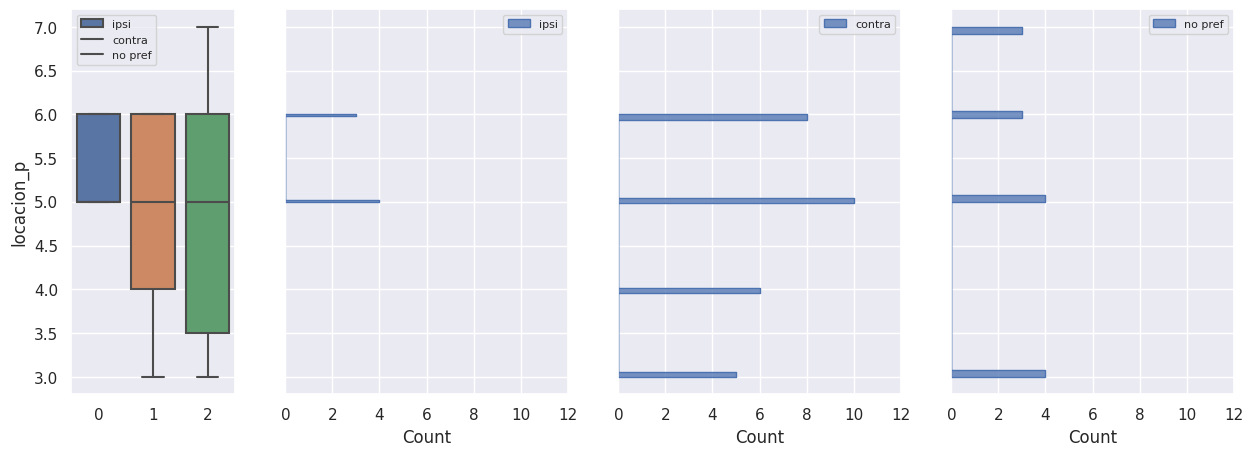

In [25]:
sns.set(style="darkgrid")

rf_dep_no_sig = no_pref_depth['locacion_l']
rf_dep_sig = pref_depth
rf_contra = df_contra_depth['locacion_l']
rf_ipsi = df_ipsi_depth['locacion_l']
fig,(ax_box, ax1,ax2,ax3) = plt.subplots(1,4, sharey=True,figsize=(15,5), gridspec_kw={"width_ratios": (.11, .19,0.19,0.19)})
g = sns.boxplot([rf_ipsi.values,rf_contra.values,rf_dep_no_sig.values], ax=ax_box,orient='vertical')#,palette=my_colors)
g.legend(['ipsi', 'contra','no pref'], prop={'size': 8})
g.set_ylabel('locacion_l')
g1=sns.histplot(y=rf_ipsi.values, element="step",bins=50,ax=ax1,legend=True)
g1.legend(['ipsi'], prop={'size': 8})
ax1.set_xlim(0,12)
g2=sns.histplot(y=rf_contra.values, element="step",bins=50,ax=ax2,legend=True)
g2.legend(['contra'], prop={'size': 8})
ax2.set_xlim(0,12)
g3=sns.histplot(y=rf_dep_no_sig.values, element="step",bins=50, ax=ax3,legend=True)
g3.legend(['no pref'], prop={'size': 8})
ax3.set_xlim(0,12)
#sns.histplot([rf_dep_no_sig.values], element="step",bins=50,ax=ax3,legend=True)
p=stats.ttest_ind(rf_ipsi.values, rf_contra.values)[1]
print(p)

rf_dep_no_sig = no_pref_depth['locacion_p']
rf_dep_sig = pref_depth
rf_contra = df_contra_depth['locacion_p']
rf_ipsi = df_ipsi_depth['locacion_p']
fig,(ax_box, ax1,ax2,ax3) = plt.subplots(1,4, sharey=True,figsize=(15,5), gridspec_kw={"width_ratios": (.11, .19,0.19,0.19)})
g = sns.boxplot([rf_ipsi.values,rf_contra.values,rf_dep_no_sig.values], ax=ax_box,orient='vertical')#,palette=my_colors)
g.legend(['ipsi', 'contra','no pref'], prop={'size': 8})
g.set_ylabel('locacion_p')
g1=sns.histplot(y=rf_ipsi.values, element="step",bins=50,ax=ax1,legend=True)
g1.legend(['ipsi'], prop={'size': 8})
ax1.set_xlim(0,12)
g2=sns.histplot(y=rf_contra.values, element="step",bins=50,ax=ax2,legend=True)
g2.legend(['contra'], prop={'size': 8})
ax2.set_xlim(0,12)
g3=sns.histplot(y=rf_dep_no_sig.values, element="step",bins=50, ax=ax3,legend=True)
g3.legend(['no pref'], prop={'size': 8})
ax3.set_xlim(0,12)
#sns.histplot([rf_dep_no_sig.values], element="step",bins=50,ax=ax3,legend=True)
p=stats.ttest_ind(rf_ipsi.values, rf_contra.values)[1]
print(p)

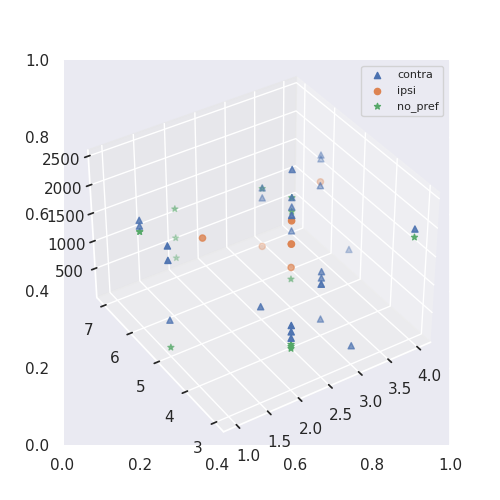

In [33]:
sns.set(style="darkgrid")
l_contra = df_contra_depth['locacion_l']
p_contra = df_contra_depth['locacion_p']
d_contra = df_contra_depth['total_depth']
l_ipsi = df_ipsi_depth['locacion_l']
p_ipsi = df_ipsi_depth['locacion_p']
d_ipsi = df_ipsi_depth['total_depth']
l_no_pref = no_pref_depth['locacion_l']
p_no_pref = no_pref_depth['locacion_p']
d_no_pref = no_pref_depth['total_depth']


fig,ax = plt.subplots(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l_contra.values,p_contra.values,d_contra.values,marker='^')
ax.scatter(l_ipsi.values,p_ipsi.values,d_ipsi.values)
ax.scatter(l_no_pref.values,p_no_pref.values,d_no_pref.values,marker='*')
#sns.scatterplot(x=l_visual.values,y=p_visual.values, ax=ax)
#ax_hist.set_xlabel('locacion_l')
plt.legend(['contra', 'ipsi','no_pref'], prop={'size': 8})
ax.view_init(37, -123)
plt.show()

Text(0.5, 1.0, 'nopref')

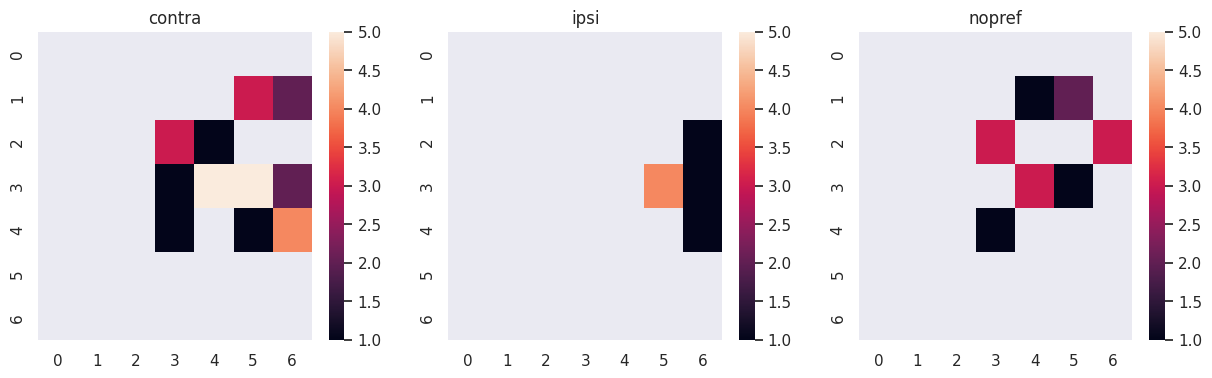

In [27]:
vmax = 5
count_df_contra = df_contra_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_ipsi = df_ipsi_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_nopref = no_pref_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})

contra_vals=count_df_contra.pivot_table(index = ['locacion_l'] ,columns=['locacion_p'],values='count')
ipsi_vals=count_df_ipsi.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')
nopref_vals=count_df_nopref.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')

contra_vals.columns.name = None 
contra_vals.index.name=None
contra_vals_all=np.full((7,7),np.nan)
contra_vals_all[contra_vals.index[0]:contra_vals.index[-1]+1, contra_vals.columns[0]:contra_vals.columns[-1]+1]=contra_vals
ipsi_vals.columns.name = None 
ipsi_vals.index.name=None
ipsi_vals_all=np.full((7,7),np.nan)
ipsi_vals_all[ipsi_vals.index[0]:ipsi_vals.index[-1]+1, ipsi_vals.columns[0]:ipsi_vals.columns[-1]+1]=ipsi_vals
nopref_vals.columns.name = None 
nopref_vals.index.name=None
nopref_vals_all=np.full((7,7),np.nan)
nopref_vals_all[nopref_vals.index[0]:nopref_vals.index[-1]+1, nopref_vals.columns[0]:nopref_vals.columns[-1]+1]=nopref_vals
fig,(ax_contra,ax_ipsi,ax_nopref) = plt.subplots(ncols=3,figsize=(15,4))
sns.heatmap(contra_vals_all,ax=ax_contra,vmax=vmax)
sns.heatmap(ipsi_vals_all,ax=ax_ipsi,vmax=vmax)
sns.heatmap(nopref_vals_all,ax=ax_nopref,vmax=vmax)
ax_contra.set_title('contra')
ax_ipsi.set_title('ipsi')
ax_nopref.set_title('nopref')

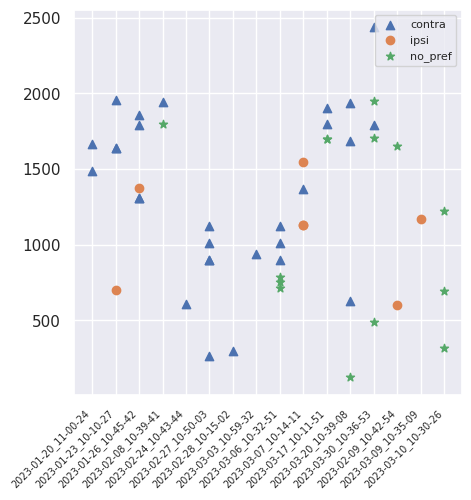

In [28]:
dt_contra = df_contra_depth['date']
d_contra = df_contra_depth['total_depth']
dt_ipsi = df_ipsi_depth['date']
d_ipsi = df_ipsi_depth['total_depth']
dt_no_pref = no_pref_depth['date']
d_no_pref = no_pref_depth['total_depth']
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(dt_contra.values,d_contra.values,marker='^')
ax.scatter(dt_ipsi.values,d_ipsi.values)
ax.scatter(dt_no_pref.values,d_no_pref.values,marker='*')
plt.xticks(rotation=45, ha='right',size=7)
plt.legend(['contra', 'ipsi','no_pref'], prop={'size': 8})

plt.show()

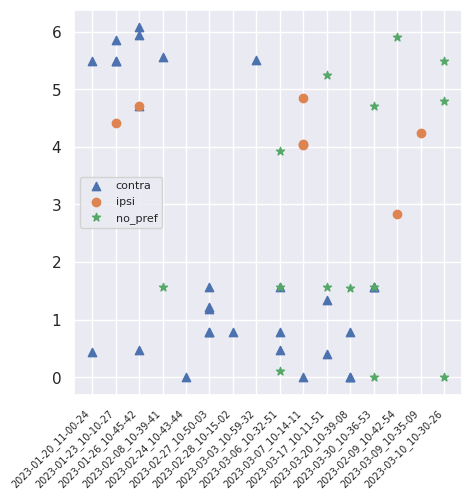

In [29]:
dt_contra = df_contra_depth['date']
d_contra = df_contra_depth['ang_all']
dt_ipsi = df_ipsi_depth['date']
d_ipsi = df_ipsi_depth['ang_all']
dt_no_pref = no_pref_depth['date']
d_no_pref = no_pref_depth['ang_all']
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(dt_contra.values,d_contra.values,marker='^')
ax.scatter(dt_ipsi.values,d_ipsi.values)
ax.scatter(dt_no_pref.values,d_no_pref.values,marker='*')
plt.xticks(rotation=45, ha='right',size=7)
plt.legend(['contra', 'ipsi','no_pref'], prop={'size': 8})

plt.show()

In [30]:
pref

,array_position,neuron_type,i_neuron,event,rad,ang,fr_max,ang_max,rad_all,ang_all,depth,vm_index,date,lat_index,p_lat
0,5,neuron,4,visual,0.832172,0.438803,85.409301,45.0,0.832172,0.438803,1250.0,-0.110176,2023-01-20_11-00-24,0.482330,3.939063e-47
1,10,mua,3,motor,1.000000,5.497787,12.421879,315.0,1.000000,5.497787,1400.0,0.644634,2023-01-20_11-00-24,0.868517,4.344073e-06
2,5,neuron,4,motor,0.925719,5.497787,20.356090,315.0,0.925719,5.497787,1250.0,0.368148,2023-01-23_10-10-27,0.737143,3.394658e-47
3,7,neuron,6,visual,0.649530,5.497787,51.081949,180.0,0.851170,5.854832,1050.0,0.470888,2023-01-23_10-10-27,0.410848,4.372728e-31
4,8,mua,3,visual,1.000000,5.497787,11.033485,315.0,1.000000,5.497787,1050.0,-0.284874,2023-01-23_10-10-27,0.744596,1.432682e-06
5,9,mua,4,visual,0.763728,4.408290,64.250709,270.0,0.763728,4.408290,450.0,-0.109407,2023-01-23_10-10-27,-0.362004,3.690864e-27
6,2,neuron,1,visual,0.784507,0.467515,38.732570,45.0,0.784507,0.467515,950.0,-0.917651,2023-01-26_10-45-42,1.000000,1.307311e-05
7,3,neuron,2,motor,1.000000,4.712389,23.541228,270.0,1.000000,4.712389,950.0,0.552960,2023-01-26_10-45-42,0.166000,2.042393e-03
8,4,neuron,3,motor,1.000000,4.712389,27.954964,270.0,1.000000,4.712389,1000.0,1.000000,2023-01-26_10-45-42,-0.421272,1.546467e-02
9,6,mua,4,visual,0.422898,6.078585,48.032521,0.0,0.422898,6.078585,1300.0,-0.593546,2023-01-26_10-45-42,0.684912,1.115762e-13
